In [38]:
import time
import numpy as np
from scipy.stats import beta
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300  
plt.rcParams['figure.figsize'] = [12, 8]

In [53]:
#thompson sampling routine given by the book
def thompson(theta, N, discount=1):
    '''
    Thompson sample to choose the arm, then simulate a pull,
    then update. Repeate N times
    Paramaters:
        Thetas ((m, )ndarray): true probabilities for m machines
        N_val (int): total number of pulls to make
        discount (float): defaults to 1 (the discount factor)
    Returns:
        Percentage of success up to each time step
    '''
    n = len(theta)
    a = np.ones(n)
    b = np.ones(n)
    X = np.random.random(N)
    traj = np.zeros(N)

    for k in range(N):
        draw = beta.rvs(a, b)
        index = np.argmax(draw)

        if X[k] <= theta[index]:
            a[index] += 1
            traj[k] = traj[k-1] + discount**(k+1)
        else:
            b[index] += 1
            traj[k] = traj[k-1]

    return traj/np.arange(1, N+1)

def AB(theta, m, beta=1):
    n = len(theta)
    probs = np.zeros(n)
    successes = 0
    for i in range(len(theta)):
        for j in range(m):
            draw = np.random.beta(1, 1)
            if draw <= theta[i]:
                probs[i] += 1
                successes += beta**((i)*m + (j+1))
    probs = probs / m
    return probs, successes

def ABExploit(theta, N, m, beta=1):
    probs, successes = AB(theta, m, beta)
    n = len(probs)
    maxProb = np.argmax(probs)

    for k in range(N - n*m):
        draw = np.random.uniform(0, 1)
        if draw <= theta[maxProb]:
            successes += beta**(n*m + k + 1)

    return successes / N


# 17.12

We run the Thompson sampling problem 20 times for $T=100, 500, 1000, 2000$ with $(\theta_1, \theta_2, \theta_3) = (0.2, 0.5, 0.7)$ and compare the resultes and runtimes. We compare results by getting a average result vector by averaging the matrix populated by each experiment run. That is, for each $T$ value we get 20 thompson sampling results that are vectors, populate a matrix where each row is one of the 20 results then average the rows. This shows what the output converges to. Additionally for each experiment and each T value we compute the average time to compute the thompson sampling for that T value and plot the computation time. 

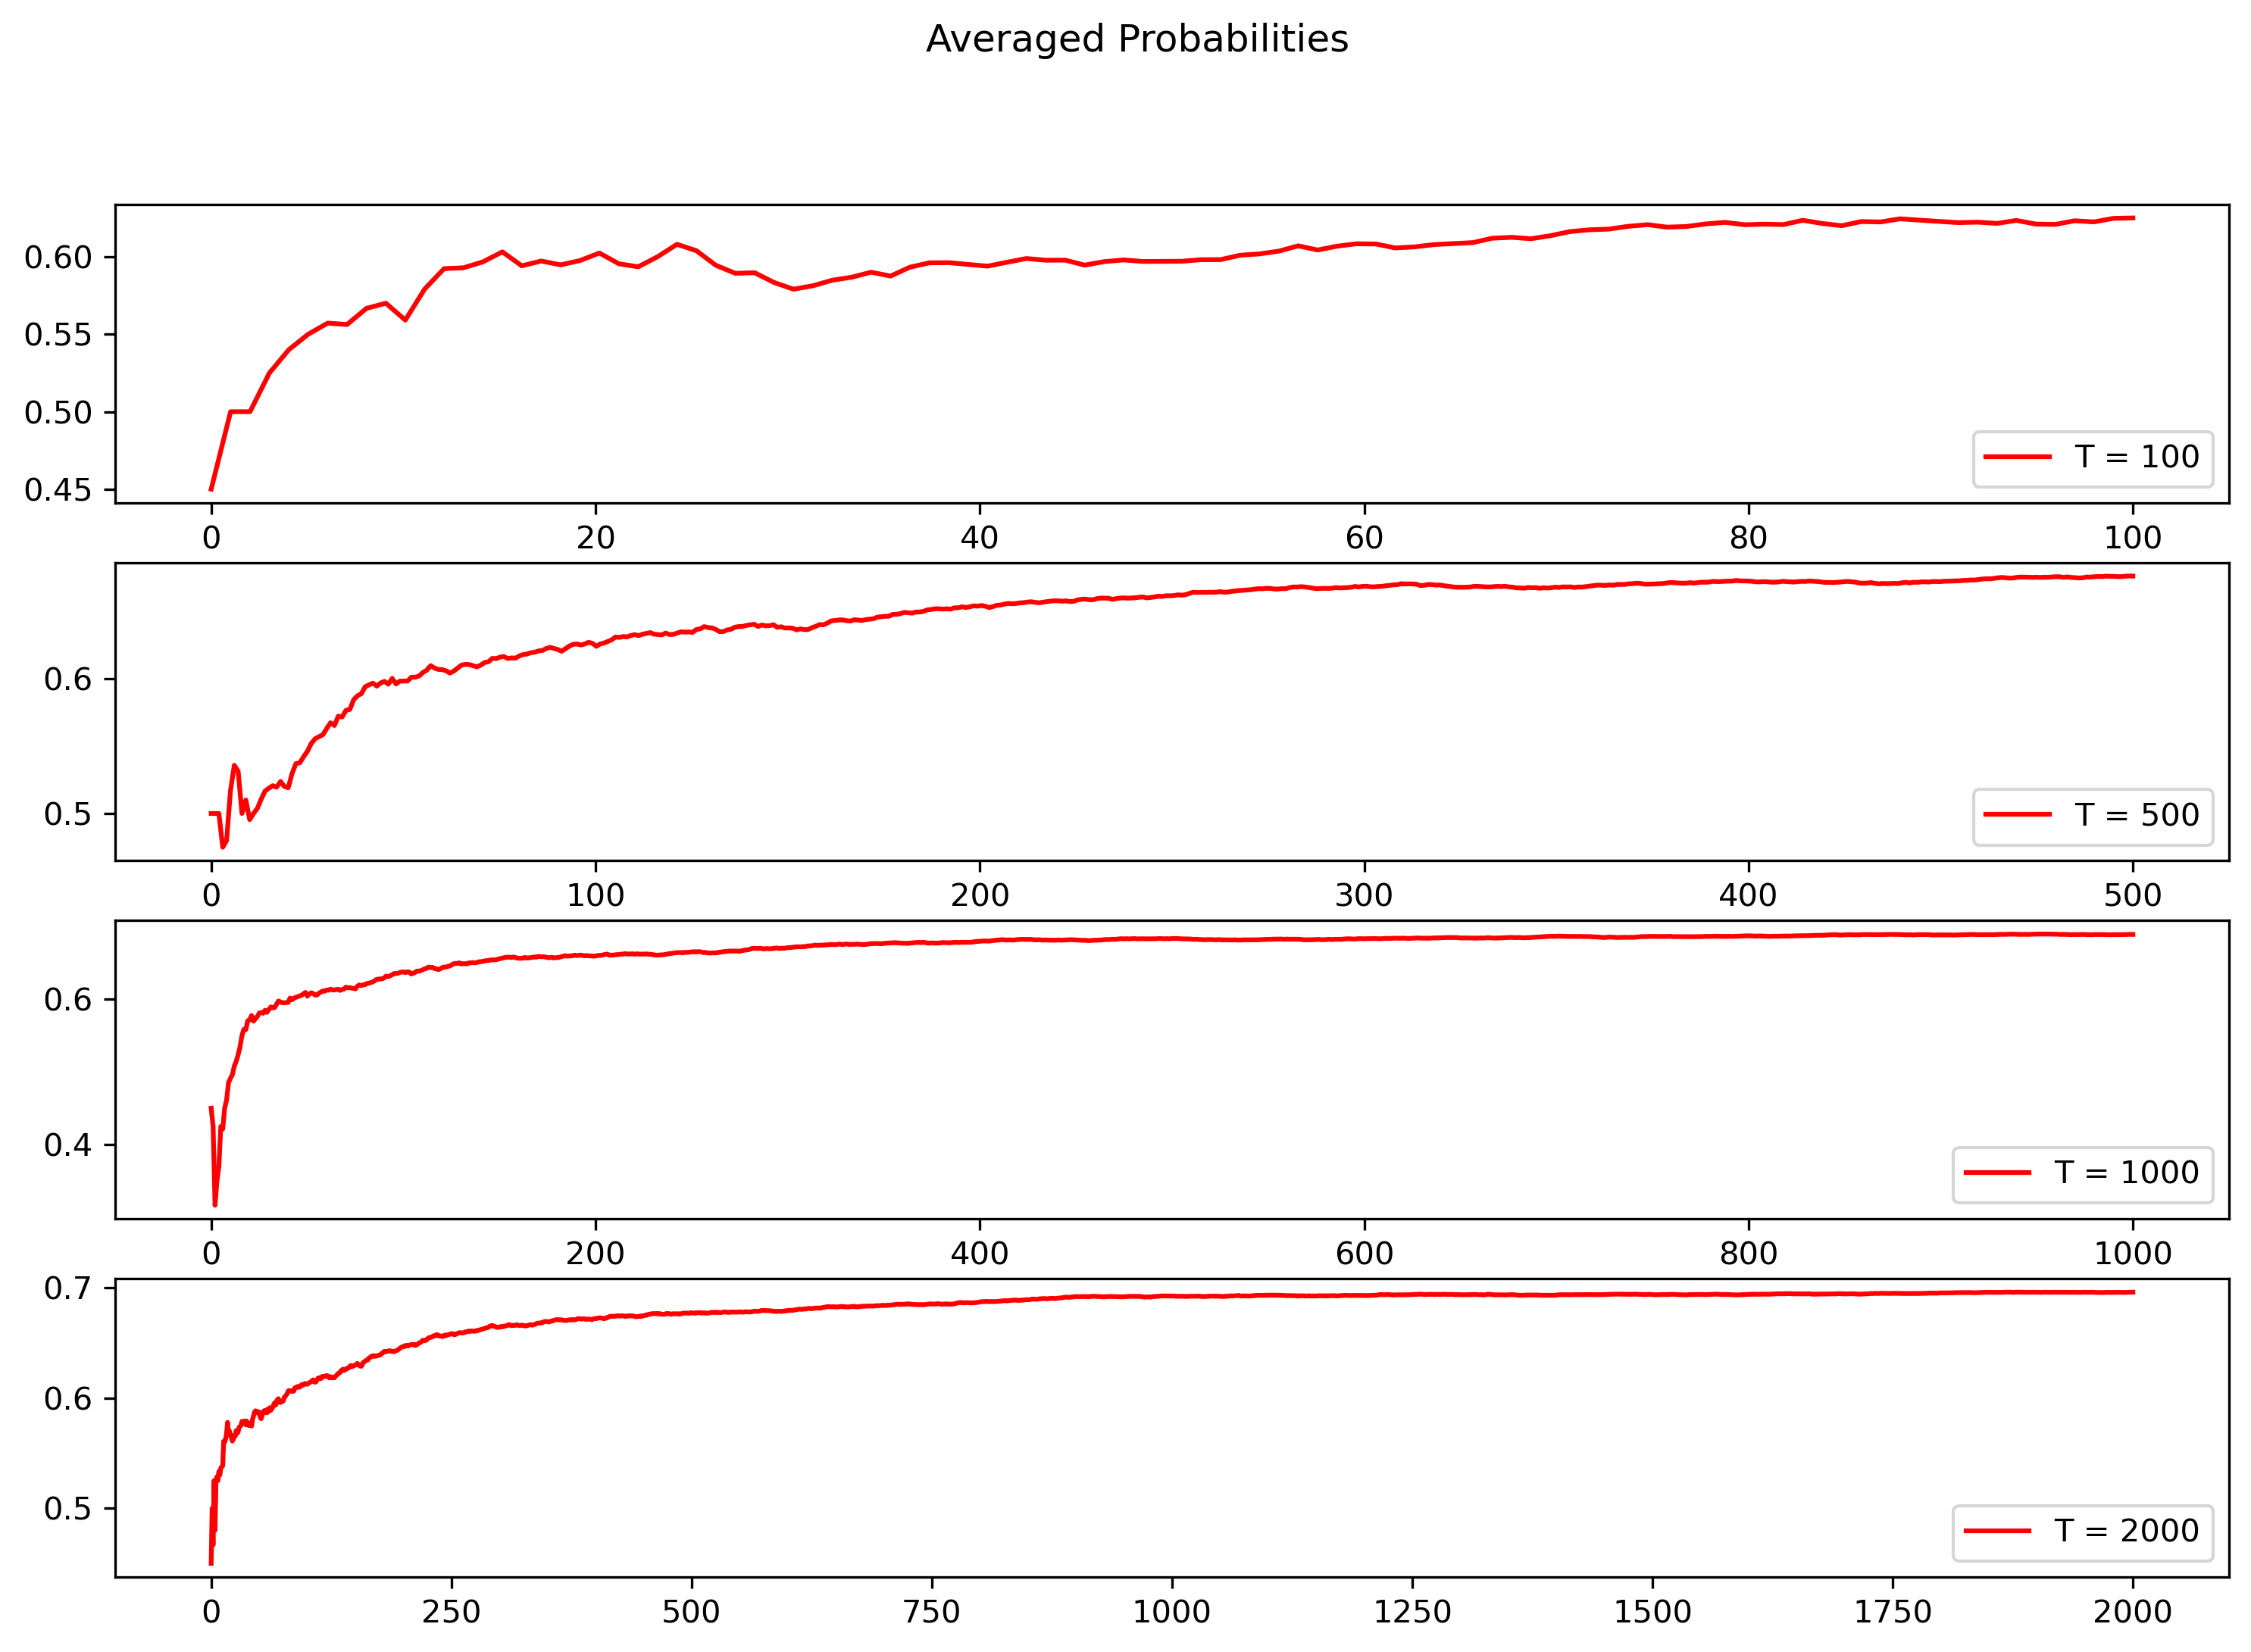

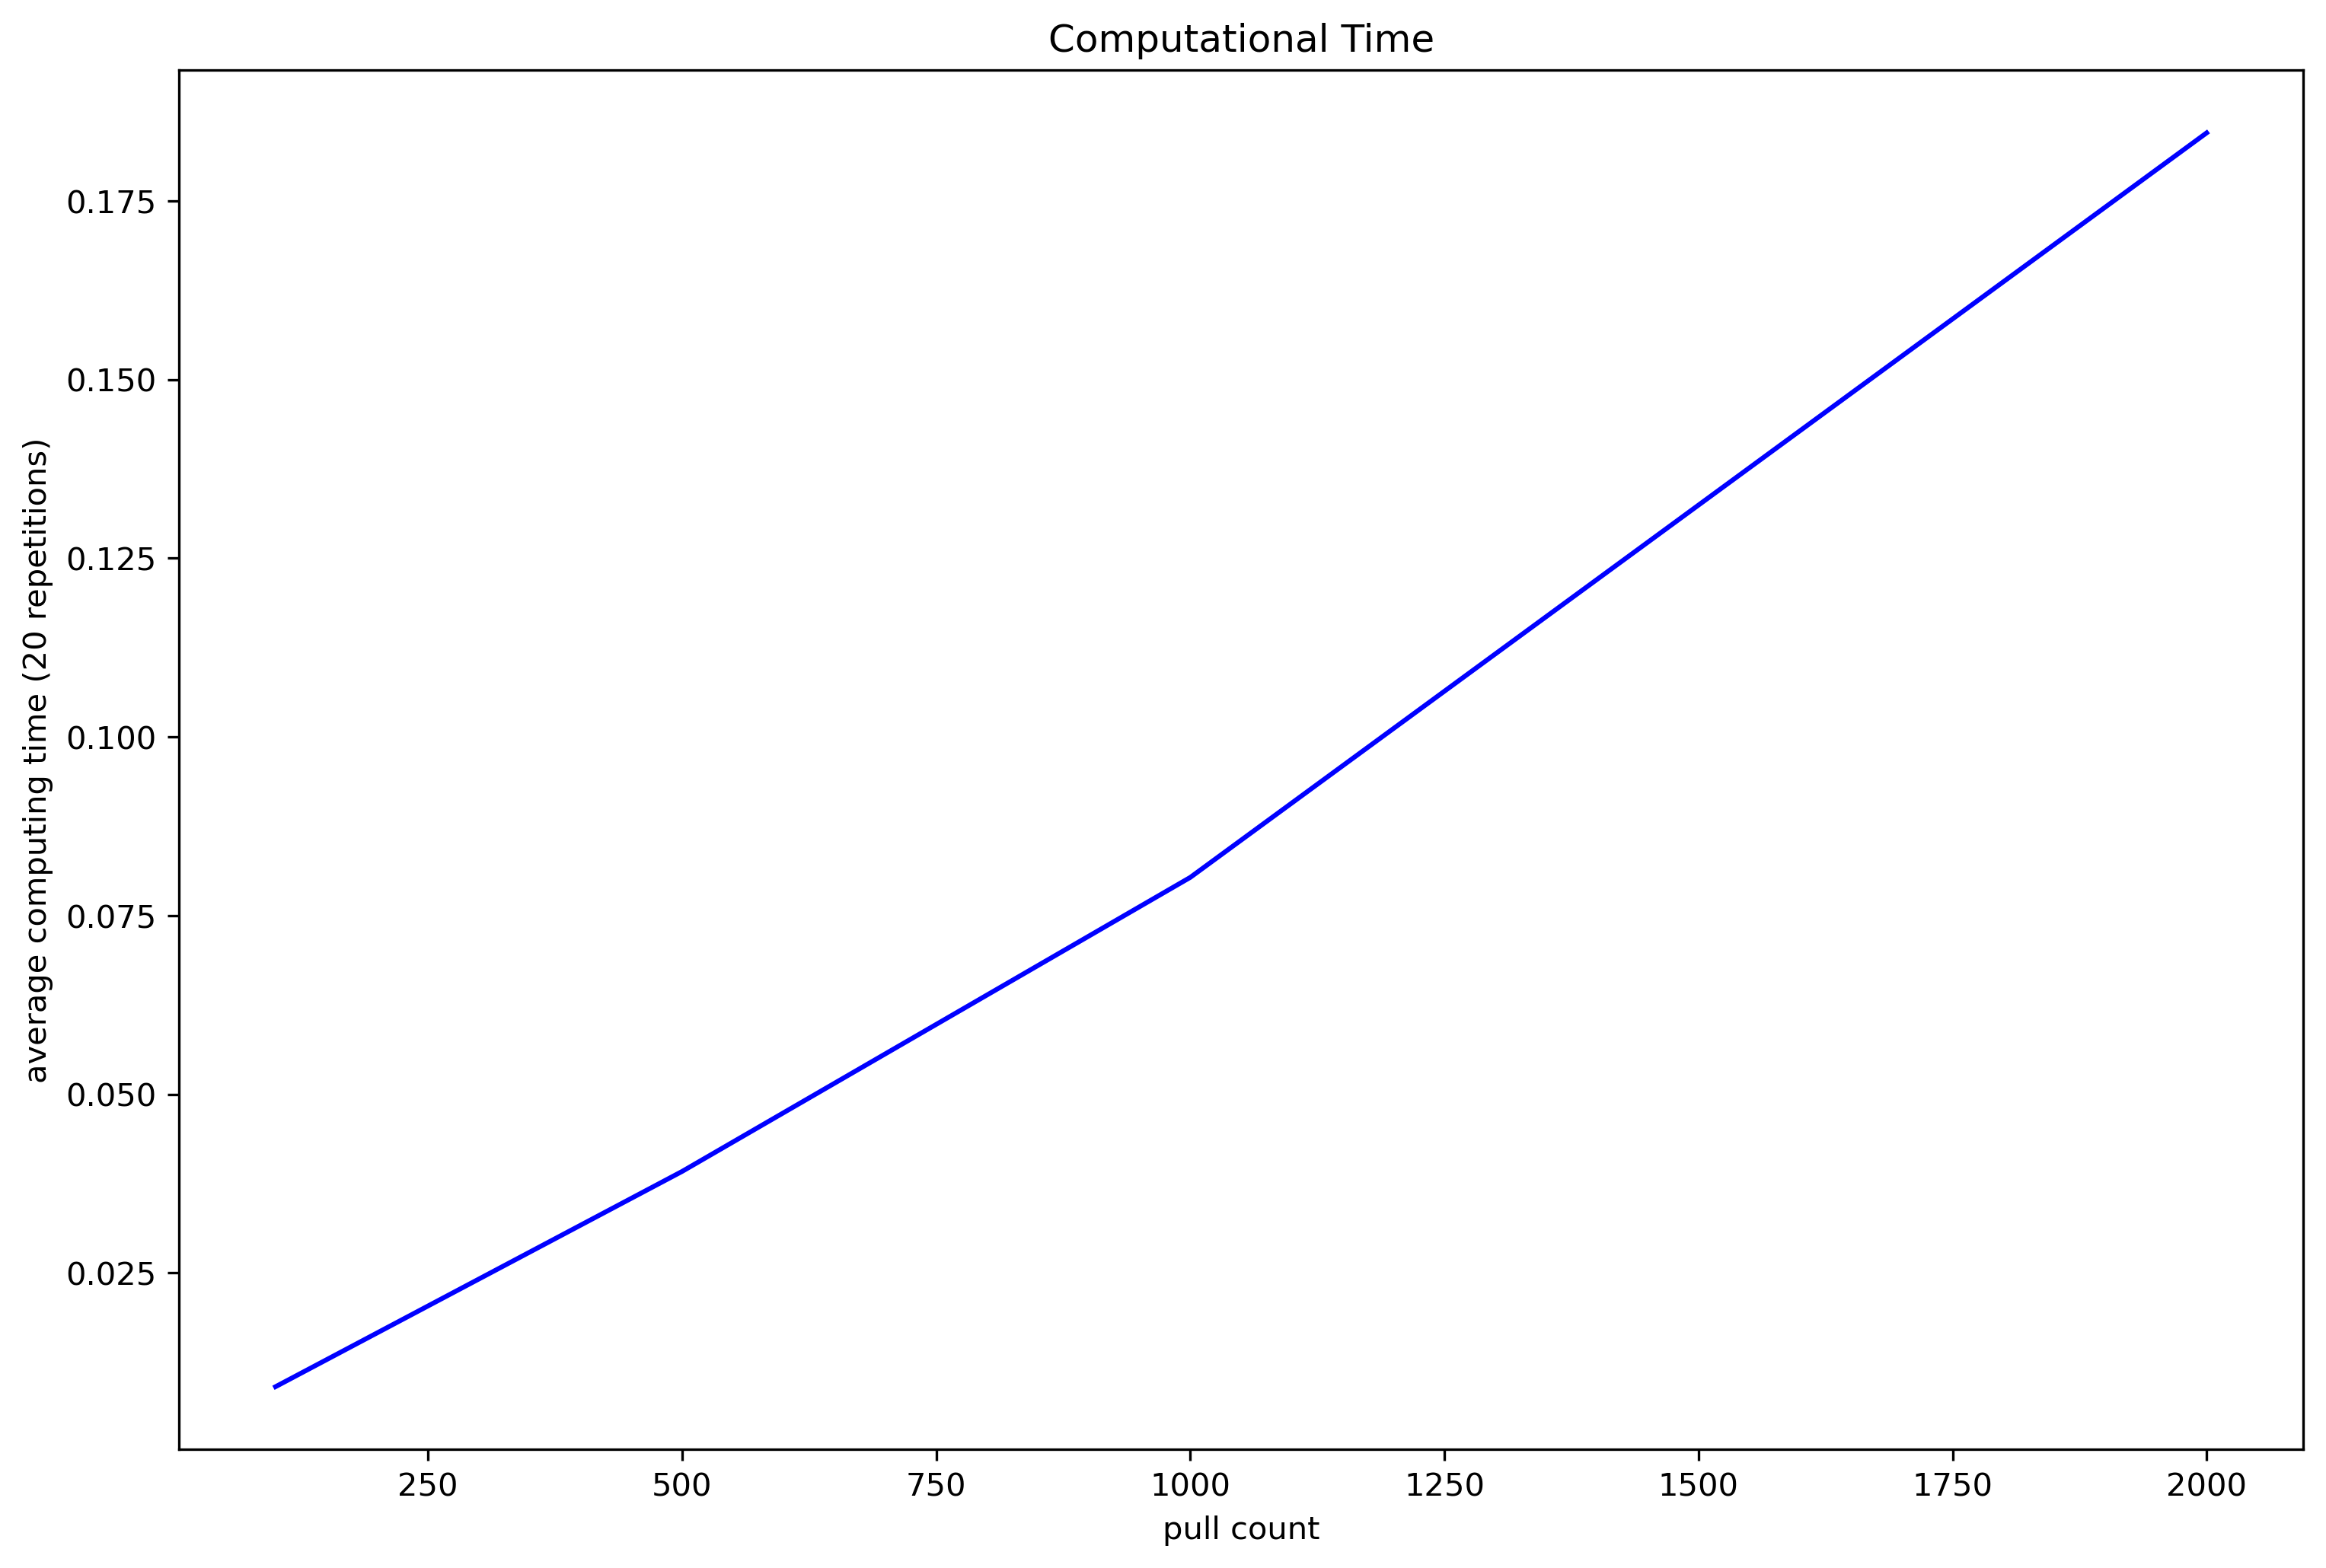

Successes: [0.6249999999999999, 0.6758, 0.68865, 0.6958749999999999]


In [67]:
#repeat experiment 20 times for each T value
repeat = 20
#arrang containing pull values
T_vals = np.array([100, 500, 1000, 2000])
#true probabilities
true_prob = np.array([0.2, 0.5, 0.7])

#list will contain arrays of averaged results for each T value
averaged_results = []
#list will contain average run times
averaged_times = []
#get the averaged results over 20 runs for each T value
for T in T_vals:
    #matrix where each row contains the result of 1 repition
    current_results = np.zeros((repeat, T))
    current_time = []
    for i in range(repeat):
        #start timing
        start = time.time()
        #result
        r = thompson(true_prob, T)
        #end timing
        end = time.time()
        current_time.append(end-start)
        #populate matrix
        current_results[i, :] = r
        
    #take average of rows of matrix and append to averaged results
    averaged_results.append(np.mean(current_results, axis=0))
    #append average times
    averaged_times.append(np.mean(current_time))

success = [result[-1] for result in averaged_results]
#get plotting domains
domains = [np.linspace(0, T, T) for T in T_vals]

fig, axs = plt.subplots(4, 1)

for i in range(4):
    domain = domains[i]
    payout = averaged_results[i]
    ax = axs[i]
    ax.plot(domain, payout, 'r', label = 'T = ' + str(T_vals[i]))
    ax.legend(loc='lower right')
plt.suptitle('Averaged Probabilities')
plt.show()



#plot computing
plt.plot(T_vals, averaged_times, 'b')
plt.xlabel('pull count')
plt.ylabel('average computing time (20 repetitions)')
plt.title('Computational Time')
plt.show()

print('Successes:', success)

# 17.13

We write a program that performs $A/B$ testing. We teach each arm $m$ times to estimate each $\theta_i$ where $i\in\{1, \dots, n\}$. Then choose the larges $\theta_i$ and use the remaining $N -nm$ pulls (where $N$ is the total number of pulls) to try to maximize the average payoff. We then compare the average payout with Thompson sampling. 

In [64]:
tSuccess = thompson(np.array([0.2, 0.5, 0.7]), 1500)[-1]

abSuccess = ABExploit(np.array([0.2, 0.5, 0.7]), 1500, 100)

print('Thompson Success:', tSuccess)
print('abSuccess:', abSuccess)

Thompson Success: 0.6913333333333334
abSuccess: 0.6626666666666666


# 17.15 

Here we now explore the relationship with a discount value (before it was defaulted to 1) to see which is better between Thompson sampling and A/B. 

In [65]:
tSuccess = thompson(np.array([0.2, 0.5, 0.7]), 1500, .95)[-1]
ABSuccess = ABExploit(np.array([0.2, 0.5, 0.7]), 1500, 100, .95)
print("Thompson Success: " + str(tSuccess))
print("AB Success: " + str(ABSuccess))

Thompson Success: 0.006216511866543036
AB Success: 0.0020908732332189485


# Final Comments

As we can see both for discounted and non-discounted Thompson sampling gives us better results. 